In [ ]:
!pip install pmdarima

In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.23.5

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
blosc2 3.2.0 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
bigf

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from google.colab import drive

from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
drive.mount('/content/drive/')
df = pd.read_csv("/content/drive/MyDrive/household_power_consumption.txt", sep=";")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


<ipython-input-2-b56a3be83c5c>:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/household_power_consumption.txt", sep=";")


In [ ]:
# Объединяем Date + Time
df["DateTime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")
df = df.drop(columns=["Date", "Time"])

# Приводим столбцы к числовому виду
numeric_columns = [
    "Global_active_power", "Global_reactive_power", "Voltage",
    "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"
]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="coerce")

df = df.dropna()

# Группируем данные по часам (было по минутам...)
df = df.resample("h", on="DateTime").mean().reset_index()
df = df.interpolate(method="linear")

df = df.dropna()

# Добавляем временные признаки
df["hour"] = df["DateTime"].dt.hour
df["dayofweek"] = df["DateTime"].dt.dayofweek
df["month"] = df["DateTime"].dt.month
df["year"] = df["DateTime"].dt.year
df["day"] = df["DateTime"].dt.day
df["day_of_year"] = df["DateTime"].dt.dayofyear

# Убедимся, что datetime индекс
df["DateTime"] = pd.to_datetime(df["DateTime"])
df = df.set_index("DateTime").sort_index()

df = df.dropna()

# Целевой ряд
target = df["Global_active_power"]

In [ ]:
def test_stationarity(series, title='Временной ряд'):
    print(f"Результаты теста Дики-Фуллера для: {title}")
    result = adfuller(series.dropna(), autolag='AIC')
    print(f"p-значение: {result[1]:.4f}")
    if result[1] > 0.05:
        print("Ряд нестационарен")
    else:
        print("Ряд стационарен")

test_stationarity(df['Global_active_power'].dropna(), title='Global_active_power')

Результаты теста Дики-Фуллера для: Global_active_power
p-значение: 0.0000
Ряд стационарен


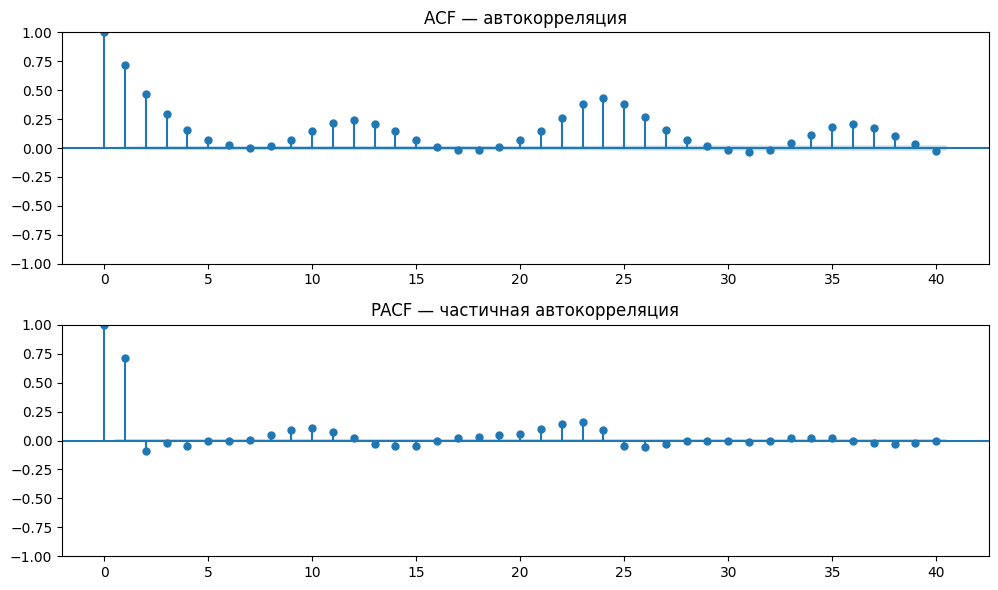

In [ ]:
# Оставим только нужный столбец
power_series = df['Global_active_power'].dropna()

# Строим ACF и PACF
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

plot_acf(power_series, lags=40, ax=axes[0], title='ACF — автокорреляция')
plot_pacf(power_series, lags=40, ax=axes[1], title='PACF — частичная автокорреляция')

plt.tight_layout()
plt.show()

In [ ]:
# Прогноз на 24 часа
train_target = target[-10000:-24]
test_target = target[-24:]

In [ ]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,month,year,day,day_of_year
DateTime,,,,,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,17,5,12,2006,16,350
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,18,5,12,2006,16,350
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,19,5,12,2006,16,350
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,20,5,12,2006,16,350
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,21,5,12,2006,16,350


In [ ]:
model = SARIMAX(train_target,
                order=(3, 0, 3),
                seasonal_order=(1, 1, 1, 24), # суточная сезонность
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit(disp=False)

forecast = results.forecast(steps=24)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


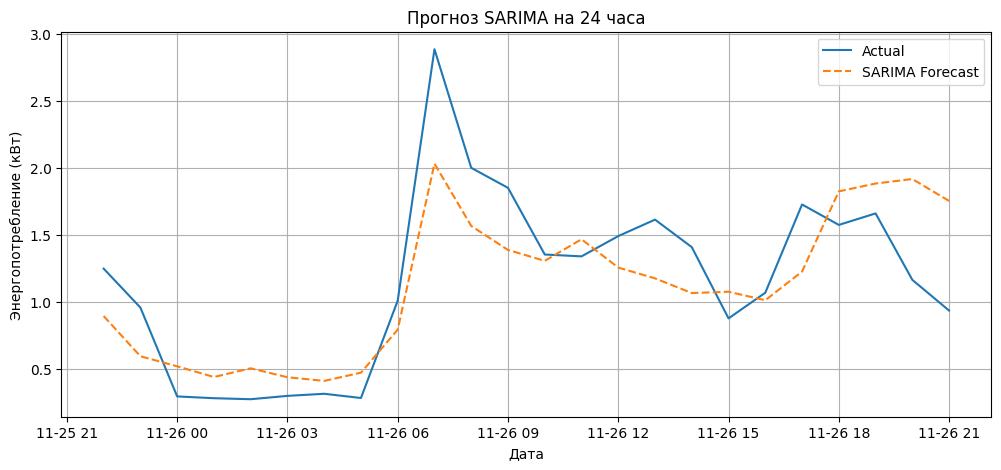

In [ ]:
forecast_series = pd.Series(forecast, index=test_target.index)

plt.figure(figsize=(12, 5))
plt.plot(test_target.index, test_target.values, label="Actual")
plt.plot(forecast_series.index, forecast_series.values, label="SARIMA Forecast", linestyle="--")
plt.title("Прогноз SARIMA на 24 часа")
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Энергопотребление (кВт)')
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Вычисляем метрики
mae = mean_absolute_error(test_target, forecast_series)
rmse = mean_squared_error(test_target, forecast_series)
mape = np.mean(np.abs((test_target - forecast_series) / test_target)) * 100

print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")
print(f"MAPE = {mape:.2f}%")


MAE  = 0.3212
RMSE = 0.1521
MAPE = 35.15%
